In [1]:
def download(path):
    import os
    from six.moves import urllib

    fname = path.split('/')[-1]
    if os.path.exists(fname):
        return fname

    print('Downloading ' + path)

    def progress(count, block_size, total_size):
        if count % 20 == 0:
            print('Downloaded %02.02f/%02.02f MB' % (
                count * block_size / 1024.0 / 1024.0,
                total_size / 1024.0 / 1024.0), end='\r')

    filepath, _ = urllib.request.urlretrieve(
        path, filename=fname, reporthook=progress)
    return filepath

In [2]:
import tensorflow as tf
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize

def get_vgg_model():
    download('https://s3.amazonaws.com/cadl/models/vgg16.tfmodel')
    with open("vgg16.tfmodel", mode='rb') as f:
        graph_def = tf.GraphDef()
        try:
            graph_def.ParseFromString(f.read())
        except:
            print('try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ' +
                  'to environment.  e.g.:\n' +
                  'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython\n' +
                  'See here for info: ' +
                  'https://github.com/tensorflow/tensorflow/issues/582')

    download('https://s3.amazonaws.com/cadl/models/synset.txt')
    with open('synset.txt') as f:
        labels = [(idx, l.strip()) for idx, l in enumerate(f.readlines())]

    return {
        'graph_def': graph_def,
        'labels': labels,
        'preprocess': preprocess,
        'deprocess': deprocess
    }


def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)


def deprocess(img):
    return np.clip(img * 255, 0, 255).astype(np.uint8)

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
import IPython.display as ipyd
import tensorflow as tf
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [4]:
net = get_vgg_model()

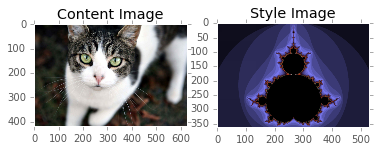

In [5]:
content_og = plt.imread('tabby.jpg')[..., :3]
style_og = plt.imread('mandelbrot3.png')[..., :3]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')

In [8]:
tf.reset_default_graph()
g = tf.Graph()
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess:
    tf.import_graph_def(net['graph_def'], name='net')
    names = [op.name for op in g.get_operations()]
    x = g.get_tensor_by_name(names[0] + ":0")
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={x: style_img,
                    'net/dropout_1/random_uniform:0': [[1.0]],
                    'net/dropout/random_uniform:0': [[1.0]]})
        style_activations.append(style_activation_i)
    style_features = []
    for style_activation_i in style_activations:
        s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
        gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
        style_features.append(gram_matrix.astype(np.float32))

In [9]:
style_features

[array([[  1.19563312e+06,   8.66297062e+05,   5.73131000e+05, ...,
           1.62591553e+00,   4.08446000e+05,   5.19677625e+05],
        [  8.66297062e+05,   7.32350450e+06,   2.30785475e+06, ...,
           2.52625656e+00,   8.44337000e+05,   6.65486438e+05],
        [  5.73131000e+05,   2.30785475e+06,   8.90310375e+05, ...,
           1.05298296e-01,   5.29967375e+05,   4.59496375e+05],
        ..., 
        [  1.62591553e+00,   2.52625656e+00,   1.05298296e-01, ...,
           3.70419617e+02,   9.31537628e-01,   3.74055505e-01],
        [  4.08446000e+05,   8.44337000e+05,   5.29967375e+05, ...,
           9.31537628e-01,   8.87745938e+05,   6.18648562e+05],
        [  5.19677625e+05,   6.65486438e+05,   4.59496375e+05, ...,
           3.74055505e-01,   6.18648562e+05,   5.29271188e+05]], dtype=float32),
 array([[  2.80432831e+02,   2.74184937e+02,   1.54124880e+01, ...,
           1.46493286e+02,   6.27436584e+02,   7.91141357e+02],
        [  2.74184937e+02,   1.07423310e+07, 